# Henry's model select demo

The follow is the model select program base on Decision Tree Classfier.  
Will be run on .py file instead of Jupyter Noteboook (for CSE server)

In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.base import TransformerMixin
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Mount the Google Drive to the system

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls

gdrive	sample_data


## Pre-define basic parameter for system adjustment

In [10]:
np.random.seed(1)

TRAININGFILE = '../keyword.csv'
TESTFILE = '../key_word_test.csv'
TESTSIZE = 0.1

REPORTPATH = 'model/'
MODELPATH = 'model/'

x_label_list = ['key_word_50', 'key_word_100','article_words']
y_label_list = ['topic']

topic_code = {
    'ARTS CULTURE ENTERTAINMENT': 1,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 2,
    'DEFENCE': 3,
    'DOMESTIC MARKETS': 4,
    'FOREX MARKETS': 5,
    'HEALTH': 6,
    'MONEY MARKETS': 7,
    'SCIENCE AND TECHNOLOGY': 8,
    'SHARE LISTINGS': 9,
    'SPORTS': 10,
    'IRRELEVANT': 0
}

## Pre-processing the data_set from the CSV file

In [11]:
def preprocess(df, x_label, y_label):
    '''
    Return the x and y columns for trainning
    '''

    return df[[x_label, y_label]]



# for the bag of word and label encode process
def convert_word(bag_of_word_model, label_model, data_set, x_label, y_label='topic'):
    '''
    bow model need to be pre-fit when call current function
    '''
    act_x = bag_of_word_model.transform(data_set[x_label].values)
    act_y = label_model.transform(data_set[y_label])

    return act_x, act_y

## SMOTE with different *Bag of Word* model: 
1. CountVectorizer()
2. TfidfVectorizer()

In [12]:
def smote_with_vector(df, vector_model, label_model, x_label):
    '''
    df                      data set
    vector_model            Bag of Word model
    x_label                 process x column
    y_label                 process y column
    '''
    
    count = vector_model.fit(df[x_label])

    # convert the data
    train_x, train_y = convert_word(count, label_model, df, x_label)

    # start to SMOTE
    smote = SMOTE(random_state=1)
    sm_x, sm_y = smote.fit_sample(train_x, train_y)

    # re-cover the data
    new_x = count.inverse_transform(sm_x)
    new_x = pd.Series([','.join(item) for item in new_x])

    return new_x, sm_y


## Implement the model pre-processing

For **GridSearch** and also implement *StratifiedKFold* for cross-vaildation

In [13]:
def grid_search(vector, model, train_x, train_y):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)

    pipe = Pipeline([
        ('vector', vector),
        ('model', model)
    ])

    param_grid = {
        
        'model__max_depth': [16, 32, 64],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2, 4],
    }

    # param_grid = {
    #     'model__min_samples_leaf': range(1, 2),
    #     'model__splitter': ['best', 'random'],
    # }

    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)

## Implement the Score function for model evaluate
base on the topic on each topic

In [42]:
def topic_score(model, label_model, data_set, topic_name, x_label):
    test_data_set = data_set[data_set['topic'] == topic_name]
    test_x = test_data_set[x_label]
    test_y = test_data_set['topic']
    pred_y = model.predict(test_x)
    en_test_y = label_model.transform(test_y)

    f1_score = metrics.f1_score(en_test_y, pred_y, average='macro')
    accuarcy = metrics.accuracy_score(en_test_y, pred_y)
    recall_score = metrics.recall_score(en_test_y, pred_y, average='macro')

    return {
        'f1': round(f1_score, 4),
        'accuarcy': round(accuarcy, 4),
        'recall_score': round(recall_score, 4)
    }


def model_score(model, label_model, x_label, test_df):
    '''
    model       The dt model
    test_df     provide testing data set or using test file data
    '''
    
    print('Topic\tf1\taccuarcy\trecall_score')
    test_report = []

    test_df = preprocess(test_df, x_label, 'topic')

    for topic in topic_code.keys():
        result = [topic]
        result.append(topic_score(model, label_model, test_df, topic, x_label))
        test_report.append(result)

    test_report.sort(reverse=True, key=lambda x: x[1]['accuarcy'])
    for record in test_report:
        print(record)

    return test_report


def merge_x_y(data_x, data_y):
    df_x = pd.Series(data_x)
    df_x.rename_axis('x')
    df_y = pd.Series(data_y)
    df_y.rename_axis('y')

    return pd.DataFrame(list(zip(df_x, df_y)), columns=['x', 'y'])


## Define the model save function
The function will automatically save each trainning model and result report wait for further choose

In [29]:
def save_job(model, test_report, pre_vector, feature_name):
    filename = REPORTPATH+str(pre_vector)+'_'+feature_name

    joblib.dump(model, filename+'.model')
    with open(filename+'.txt', 'w') as fp:
        fp.write('Topic\tf1\taccuarcy\trecall_score\n')
        for record in test_report:
            fp.write(str(record)+'\n')


## Start to implement the main function
---

In [45]:
def model_compile(df, x_label, vector_num):

    print('Trainning topic', x_label, 'with vector num', vector_num)
    df = preprocess(df, x_label, 'topic')

    label_model = preprocessing.LabelEncoder().fit(df['topic'])
    encode_mapping = dict(zip(label_model.classes_, range(len(label_model.classes_))))

    if vector_num == 1:
        print('Coverting word to matrix using TF-IDF...', end=' ')
        x, y = smote_with_vector(df, TfidfVectorizer(), label_model, x_label)
    else:
        print('Coverting word to matrix using Count...', end=' ')
        x, y = smote_with_vector(df, CountVectorizer(), label_model, x_label)

    print('Done!')

    new_df = merge_x_y(x, y)
    train_df, test_df = train_test_split(x, test_size=0.3)
    

    #topic = topic_code.keys()

    # train_x, test_x = train_test_split(x, test_size=0.3)
    # train_y, test_y = train_test_split(y, test_size=0.3)

    # # prepared for grid-search
    # count_dt_model, count_dt_accuarcy = grid_search(CountVectorizer(), DecisionTreeClassifier(), train_x, train_y)
    # tfidf_dt_model, tfidf_dt_accuarcy = grid_search(TfidfVectorizer(norm=None), DecisionTreeClassifier(), train_x, train_y)

    # # first evaluate the data
    # pred_y = model.predict(test_x)
    # en_test_y = label_model.transform(test_y)
    # print('Total proformance')
    # print('F1 score:', metrics.f1_score(en_test_y, pred_y, average='macro'))
    # print('Accuarcy:', metrics.accuracy_score(en_test_y, pred_y))
    # print('Recall score:', metrics.recall_score(en_test_y, pred_y, average='macro'))
    # print('-'*15)
    # print('Classification Report:')
    # print(classification_report(en_test_y, pred_y))

    # # for each topic score
    # model_score(model, label_model, x_label, test_df)


    # if count_dt_accuarcy >= tfidf_dt_accuarcy:
    #     print(f'*************************************************************')
    #     print(f'Now the training set is {x_label}, and the model chosen is count')
    #     print(f'The accuracy is {count_dt_accuarcy}')
    #     return count_dt_model,label_model,encode_mapping
    # else:
    #     print(f'*************************************************************')
    #     print(f'Now the training set is {x_label}, and the model chosen is tfidf')
    #     print(f'The accuracy is {tfidf_dt_accuarcy}')
    #     return tfidf_dt_model,label_model,encode_mapping

def model_evaluate(model, x_label, label_model, df, encode_mapping, vector_num):
    print('Start to evalute', x_label, 'model')
    test_set = preprocess(df, x_label, 'topic')
    test_x = test_set[x_label]
    test_y = test_set['topic']
    topics = list(set(test_set['topic']))

    # evalute total performance
    pred_y = model.predict(test_x)
    en_test_y = label_model.transform(test_y)
    print('Total proformance')
    print('F1 score:', metrics.f1_score(en_test_y, pred_y, average='macro'))
    print('Accuarcy:', metrics.accuracy_score(en_test_y, pred_y))
    print('Recall score:', metrics.recall_score(en_test_y, pred_y, average='macro'))
    print('-'*15)
    print('Classification Report:')
    print(classification_report(en_test_y, pred_y))

    # evalute all the topic performance
    model_report = model_score(model, label_model, x_label, df)

    # save current model and performance
    save_job(model, model_report, vector_num, x_label)

    # for figure
    conf_matrix = confusion_matrix(en_test_y, pred_y)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=label_model.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()
    #plt.savefig('model/'+str(vector_num)+'_'+x_label+'.png')


### For test/debug

In [46]:
%%time
x_label = 'key_word_50'
vector_num = 2

df = pd.read_csv(TRAININGFILE)

model_compile(df, x_label, vector_num)

# model, label_model, encode_mapping = 

Trainning topic key_word_50 with vector num 2
Coverting word to matrix using Count...Done!
Total shape: (52074, 2)
X_shape: (52074,)
Y_shape: (52074,)
0         4
1         7
2        10
3         4
4         6
         ..
52069    10
52070    10
52071    10
52072    10
52073    10
Name: y, Length: 52074, dtype: int64
CPU times: user 8.56 s, sys: 153 ms, total: 8.71 s
Wall time: 8.74 s


## start to test different model
---

For one topic testing

Trainning topic key_word_50 with vector num 1
*************************************************************
Now the training set is key_word_50, and the model chosen is count_clf_NB
The accuracy is 0.9406805340323805
Start to evalute key_word_50 model
Total proformance
F1 score: 0.43573387653540774
Accuarcy: 0.652
Recall score: 0.5048479742987751
---------------
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.18      0.13      0.15        15
           2       0.43      0.46      0.44        13
           3       0.09      0.50      0.15         2
           4       0.48      0.58      0.53        48
           5       0.62      0.57      0.59        14
           6       0.81      0.71      0.76       266
           7       0.47      0.52      0.49        69
           8       0.00      0.00      0.00         3
           9       0.31      0.57      0.40         7
          10     

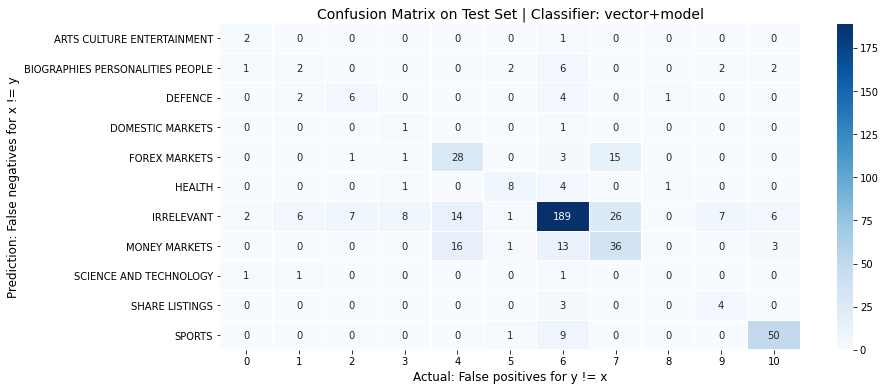

CPU times: user 26.1 s, sys: 724 ms, total: 26.8 s
Wall time: 53.2 s


In [0]:
%%time
x_label = 'key_word_50'
vector_num = 1

df = pd.read_csv(TRAININGFILE)
test_df = pd.read_csv(TESTFILE)
model, label_model, encode_mapping = model_compile(df, x_label, vector_num)
model_evaluate(model, x_label, label_model, test_df, encode_mapping, vector_num)

For mult-topic testing

In [0]:
%%time

# load data
df = pd.read_csv(TRAININGFILE)
test_df = pd.read_csv(TESTFILE)
for x_label in x_label_list:
    for vector_num in [1, 2]:
        model, label_model, encode_mapping = model_compile(df, x_label, vector_num)
        model_evaluate(model, x_label, label_model, test_df, encode_mapping, vector_num)

In [0]:
df = pd.read_csv(TRAININGFILE)
train = preprocess(df, 'key_word_50', 'topic')
print(train)

key_word_50          topic
0     open,cent,cent,cent,stock,rate,end,won,won,won...  FOREX MARKETS
1     end,end,day,day,day,point,time,bank,early,year...  MONEY MARKETS
2     socc,socc,world,world,stat,stat,stat,stat,gove...         SPORTS
3     open,cent,cent,end,play,unit,made,bank,bank,tu...  FOREX MARKETS
4     minut,minut,minut,day,friday,friday,race,time,...     IRRELEVANT
...                                                 ...            ...
9495  south,scient,capit,intern,year,year,set,set,se...        DEFENCE
9496  stock,stock,stock,week,play,friday,point,gover...     IRRELEVANT
9497  rate,million,million,dollar,dollar,trad,newsro...  FOREX MARKETS
9498  week,week,end,day,arm,man,die,polic,polic,year...     IRRELEVANT
9499  market,econom,econom,econom,econom,econom,econ...  FOREX MARKETS

[9500 rows x 2 columns]


## For Google Colab running

Trainning topic article_words with vector num 1
*************************************************************
Now the training set is article_words, and the model chosen is tfidf_clf_NB
The accuracy is 0.9496102744238009
Start to evalute article_words model
Total proformance
F1 score: 0.3841546611716652
Accuarcy: 0.652
Recall score: 0.4157672990624936
---------------
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.33      0.15         3
           1       0.30      0.20      0.24        15
           2       0.47      0.54      0.50        13
           3       0.00      0.00      0.00         2
           4       0.43      0.42      0.42        48
           5       0.56      0.36      0.43        14
           6       0.81      0.74      0.77       266
           7       0.43      0.54      0.48        69
           8       0.00      0.00      0.00         3
           9       0.27      0.57      0.36         7
          10

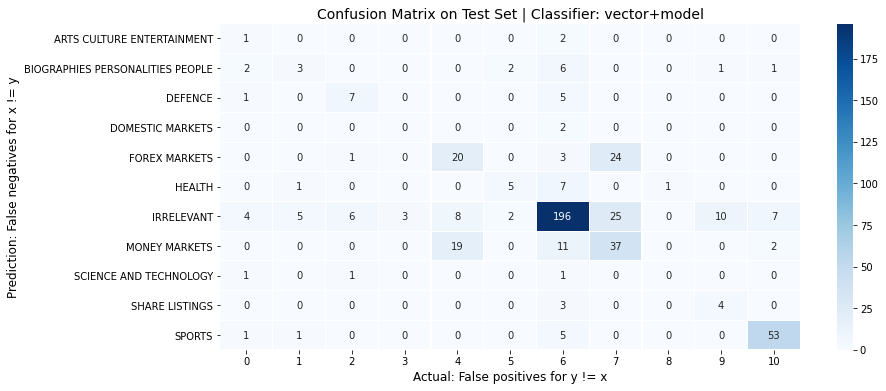

Trainning topic article_words with vector num 2


KeyboardInterrupt: ignored

In [0]:
%%time

x_label = 'article_words'

# load data
df = pd.read_csv(TRAININGFILE)
test_df = pd.read_csv(TESTFILE)
for vector_num in [1, 2]:
    model, label_model, encode_mapping = model_compile(df, x_label, vector_num)
    model_evaluate(model, x_label, label_model, test_df, encode_mapping, vector_num)

In [0]:
%%time

x_label = 'article_words'

# load data
df = pd.read_csv(TRAININGFILE)
train_df, test_df = train_test_split(df, test_size=0.2)
for vector_num in [1, 2]:
    model, label_model, encode_mapping = model_compile(df, x_label, vector_num)
    model_evaluate(model, x_label, label_model, test_df, encode_mapping, vector_num)